#### Labels transfer of cell states from gut healthy adult single-cell RNA sequencing cells to Xenium add-on panel data with `scANVI`
- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Date of creation:** 31th July 2024
- **Last modified date:** 31th July 2024

##### Import packages

In [38]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

##### Setup working environment

In [39]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [40]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [41]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [42]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in data

In [43]:
input = '/../../../gut_project/Processed_data/Gut_data/Healthy_reference/Integrated/Healthy_integrated_data_all_genes.h5ad'
adata_ref = sc.read_h5ad(input)

In [44]:
X_is_raw(adata_ref)

True

In [45]:
# upload h5 object
adata_xenium = sc.read_10x_h5('/../../../gut_project/raw_data/Xenium_10X_datasets/Gut_samples/Non-diseased_pre-designed_and_add-on_panel/outs/cell_feature_matrix.h5')

reading /mnt/LaCIE/annaM/gut_project/raw_data/Xenium_10X_datasets/Gut_samples/Non-diseased_pre-designed_and_add-on_panel/outs/cell_feature_matrix.h5
 (0:00:00)


In [46]:
X_is_raw(adata_xenium)

True

### Prepare reference dataset

+ leave only adult data

In [47]:
condition_to_keep = ['Healthy adult', 'Adult Ulcerative Colitis Non-inflamed']

In [48]:
adata_ref = adata_ref[adata_ref.obs['Diagnosis'].isin(condition_to_keep), :]

+ Leave only colon data

In [49]:
condition_to_keep = ['Large Intestine', 'Rectum', 'Epithelium', 'Lamina Propria']

In [50]:
adata_ref = adata_ref[adata_ref.obs['Location'].isin(condition_to_keep), :]

+ Modify cell states for easier processing

In [51]:
mapping_states = {
    'Stromal 1 (ADAMDEC1+)': 'Fibroblasts',
    'Stromal 2 (NPY+)': 'Fibroblasts',
    'Stromal 3 (C7+)': 'Fibroblasts',
    'Stromal 3 (KCNN3+)': 'Fibroblasts',
    'Stromal 2 (CH25H+)': 'Fibroblasts',
    'Fibroblasts ADAMDEC1': 'Fibroblasts',
    'Fibroblasts SMOC2 PTGIS': 'Fibroblasts',
    'Stromal 1 (CCL11+)': 'Fibroblasts',
    'Fibroblasts KCNN3 LY6H': 'Fibroblasts',
    'Fibroblasts SFRP2 SLPI': 'Fibroblasts',
    'Fibroblasts NPY SLITRK6': 'Fibroblasts',
    'Activated fibroblasts CCL19 ADAMADEC1': 'Fibroblasts',
    'Inflammatory fibroblasts IL11 CHI3L1': 'Fibroblasts',
    'Stromal 4 (MMP1+)': 'Fibroblasts',
    'Transitional Stromal 3 (C3+)': 'Fibroblasts',
    'cycling stromal': 'Fibroblasts',
    'mLN Stroma (FMO2+)': 'Fibroblasts',
    'Inflammatory fibroblasts IL11 CHI3L1': 'Fibroblasts',
    'Stromal Cycling cells': 'Fibroblasts',

    'Mesoderm 2 (ZEB2+)': 'Mesoderm',
    'Mesoderm 1 (HAND1+)': 'Mesoderm',

    'SMC (PLPP2+)': 'SMC',
    'SMC (PART1/CAPN3+)': 'SMC',

    'myofibroblast (RSPO2+)': 'Myofibroblasts',
    'Myofibroblasts GREM1 GREM2': 'Myofibroblasts',
    'Myofibroblasts HHIP NPNT': 'Myofibroblasts',
    'myofibroblast': 'Myofibroblasts',

    'Immature pericyte': 'Pericytes',
    'Contractile pericyte (PLN+)': 'Pericytes',
    'angiogenic pericyte': 'Pericytes',
    'Pericytes HIGD1B STEAP4': 'Pericytes',
    'Pericyte': 'Pericytes',
    'Pericytes RERGL NTRK2': 'Pericytes',

    'Mesothelium': 'Mesothelium',
    'Mesothelium (RGS5+)': 'Mesothelium',
    'Mesothelium (PRG4+)': 'Mesothelium',

    'T cells Naive CD4': 'CD4 T',
    'T cells CD4 IL17A': 'CD4 T',
    'Th1': 'CD4 T',
    'SELL+ CD4 T': 'CD4 T',
    'IELs ID3 ENTPD1': 'CD8 T',
    'Th17': 'CD4 T',
    'Tfh': 'CD4 T',
    'T cells CD4 FOSB': 'CD4 T',
    'Tregs': 'Tregs',
    'Treg': 'Tregs',
    'Activated CD4 T': 'CD4 T',
    'Activated T': 'CD4 T',
    'Activated CD8 T': 'CD8 T',
    'CX3CR1+ CD8 Tmem': 'CD8 T',
    'T cells CD8': 'CD8 T',
    'T cells CD8 KLRG1': 'CD8 T',
    'CD8 Tmem': 'CD8 T',
    'SELL+ CD8 T': 'CD8 T',
    'NK-like cells ID3 ENTPD1': 'NK',
    'NK cell': 'NK',
    'NK cells KLRF1 CD3G-': 'NK',
    'NK cells KLRF1 CD3G-': 'NK',
    'NK T cell': 'NK',
    'gdT': 'gdT',
    'TRGV5/7 gdT': 'gdT',
    'TRGV2 gdT': 'gdT',
    'TRGV4 gdT': 'gdT',
    'TRDV2/TRGV9 gdT': 'gdT',
    'ILCs': 'ILCs',
    'ILC3': 'ILCs',
    'ILCP': 'ILCs',
    'ILC2': 'ILCs',
    'LTi-like NCR- ILC3': 'ILCs',
    'LTi-like NCR+ ILC3': 'ILCs',
    
    'Macrophages': 'Macrophages',
    'Macrophages CCL3 CCL4': 'Macrophages',
    'LYVE1+ Macrophage': 'Macrophages',
    'Macrophages LYVE1': 'Macrophages',
    'Macrophages Metallothionein': 'Macrophages',
    'MMP9+ Inflammatory macrophage': 'Macrophages',
    'Macrophages PLA2G2D': 'Macrophages',
    'Macrophages CXCL9 CXCL10': 'Macrophages',

    'Monocytes': 'Monocytes',
    'Monocytes HBB': 'Monocytes',
    'Monocytes CHI3L1 CYP27A1': 'Monocytes',
    'Monocytes S100A8 S100A9': 'Monocytes',
    'MPO+ mono-neutrophil': 'Monocytes',

    'DC2 CD1D': 'DC',
    'DC2 CD1D-': 'DC',
    'cDC2': 'DC',
    'DC1': 'DC',
    'cDC1': 'DC',
    'pDC': 'DC',
    'Lymphoid DC': 'DC',
    'FDC': 'DC',
    'Mature DCs': 'DC',

    'Mast cells': 'Mast cells',
    'Mast cell': 'Mast cells',
    'CLC+ Mast cell': 'Mast cells',

    'Immune Cycling cells': 'Immune Cycling cells',
    'Cycling cells': 'Immune Cycling cells',

    'Megakaryocyte': 'Megakaryocytes',
    
    'Goblet cell': 'Goblet cells',
    'BEST2+ Goblet cell': 'Goblet cells',
    'Goblet cells MUC2 TFF1': 'Goblet cells',
    'Goblet cells SPINK4': 'Goblet cells',
    'Goblet cells MUC2 TFF1-': 'Goblet cells',
    'Paneth': 'Paneth cells',
    'Paneth cells': 'Paneth cells',
    'TA': 'TA',
    'Tuft': 'Tuft cells',
    'Tuft cells': 'Tuft cells',
    'Enterocyte': 'Enterocyte',
    'Enterocytes BEST4': 'Enterocyte',
    'Enterocytes TMIGD1 MEP1A GSTA1': 'Enterocyte',
    'Enterocytes TMIGD1 MEP1A': 'Enterocyte',
    'Enterocytes CA1 CA2 CA4-': 'Enterocyte',
    'Stem cells OLFM4': 'Stem cells',
    'Stem cells OLFM4 GSTA1': 'Stem cells',
    'Stem cells OLFM4 LGR5': 'Stem cells',
    'Stem cells OLFM4 PCNA': 'Stem cells',
    'Stem_Cells_GCA': 'Stem cells',
    'Stem_Cells_ext': 'Stem cells',
    'Colonocyte': 'Colonocyte',
    'Proximal progenitor': 'Proximal progenitor',
    'Distal progenitor': 'Distal progenitor',
    'EECs' : 'EECs', 
    'Enteroendocrine cells': 'EECs', 
    'M/X cells (MLN/GHRL+)': 'EECs', 
    'CLDN10+ cells': 'EECs',
    'I cells (CCK+)': 'EECs',
    'L cells': 'EECs',
    'D cells (SST+)': 'EECs',
    'L cells (PYY+)': 'EECs',
    'K cells (GIP+)': 'EECs',
    'Enterochromaffin cells': 'EECs',
    'EC cells (NPW+)': 'EECs',
    'N cells (NTS+)': 'EECs',
    'β cells (INS+)': 'EECs',

    'Endothelial cells CD36': 'Endothelial cells',
    'Endothelial cells DARC': 'Endothelial cells',
    'Endothelial cells LTC4S SEMA3G': 'Endothelial cells',

    'LEC6 (ADAMTS4+)': 'LEC',
    'LEC1 (ACKR4+)': 'LEC',
    'LEC3 (ADGRG3+)': 'LEC',
    'LEC5 (CLDN11+)': 'LEC',
    'LEC4 (STAB2+)': 'LEC',

    'Adult glia' : 'Glial cells',
    'Glial cells' : 'Glial cells',

    'Epithelial Cycling cells': 'TA',
}

In [52]:
adata_ref.obs['seed_labels'] = adata_ref.obs['Cell States'].astype('category')

In [53]:
existing_categories = set(adata_ref.obs['seed_labels'].cat.categories)

new_categories = set(mapping_states.values())

categories_to_add = new_categories - existing_categories

In [59]:
adata_ref.obs['seed_labels'].value_counts()

seed_labels
TA                       34601
Plasma cells             26139
Enterocyte               24019
Stem cells               16848
Fibroblasts              14422
CD4 T                    13279
IgA plasma cell          12689
Colonocyte               11650
Goblet cells              9944
Macrophages               7173
CD8 T                     5485
B cells                   4016
BEST4+ epithelial         3166
NK                        2648
Mast cells                2593
gdT                       2215
DC                        2130
Tregs                     1591
Myofibroblasts            1532
Glial cells               1211
Pericytes                 1020
Immune Cycling cells       895
Tuft cells                 892
Mature venous EC           806
Memory B                   749
Mature arterial EC         674
ILCs                       481
Monocytes                  458
LEC                        374
IgG plasma cell            339
Naive B                    318
EECs                       

In [55]:
adata_ref.obs['seed_labels'] = adata_ref.obs['seed_labels'].cat.add_categories(categories_to_add)

In [56]:
adata_ref.obs.loc[adata_ref.obs['Cell States'].isin(mapping_states.keys()), 'seed_labels'] = \
    adata_ref.obs['Cell States'].map(mapping_states)

In [58]:
adata_ref = adata_ref[~adata_ref.obs['seed_labels'].isin(['Endothelial cells']), :]

+ Save raw counts

In [60]:
adata_ref.raw = adata_ref

In [61]:
adata_xenium.raw = adata_xenium

+ prepare xenium data

In [62]:
adata_xenium.obs['seed_labels'] = 'Unknown'

In [63]:
adata_xenium.obs['Donor_ID'] = 'Xenium_donor_1'

In [64]:
adata_xenium.obs['Library_Preparation_Protocol'] = 'Xenium'

In [65]:
adata_xenium.obs['Study_name'] = '10X_Xenium_gut_data'

+ Concatenate datasets

In [66]:
adata = adata_ref.concatenate(adata_xenium, batch_key = 'dataset', batch_categories = ['reference', 'query'], join='inner', index_unique = None)

#### Run scVI

In [67]:
adata.layers['counts'] = adata.X.copy()

In [68]:
scvi.model.SCVI.setup_anndata(adata, 
                              categorical_covariate_keys=['Donor_ID', 
                                                          'Library_Preparation_Protocol', 
                                                          'Study_name'],
                              labels_key = "seed_labels", 
                              layer = 'counts')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [69]:
scvi_model = scvi.model.SCVI(adata,
                            n_latent = 50, 
                            n_layers = 3, 
                            dispersion = 'gene-batch', 
                            gene_likelihood = 'nb')

In [70]:
scvi_model.train(200, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = "gpu",
                 devices = [1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 200/200: 100%|█| 200/200 [1:05:48<00:00, 21.56s/it, v_num=1, train_loss_step=103, train_loss_epo

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [1:05:48<00:00, 19.74s/it, v_num=1, train_loss_step=103, train_loss_epo


In [71]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

#### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

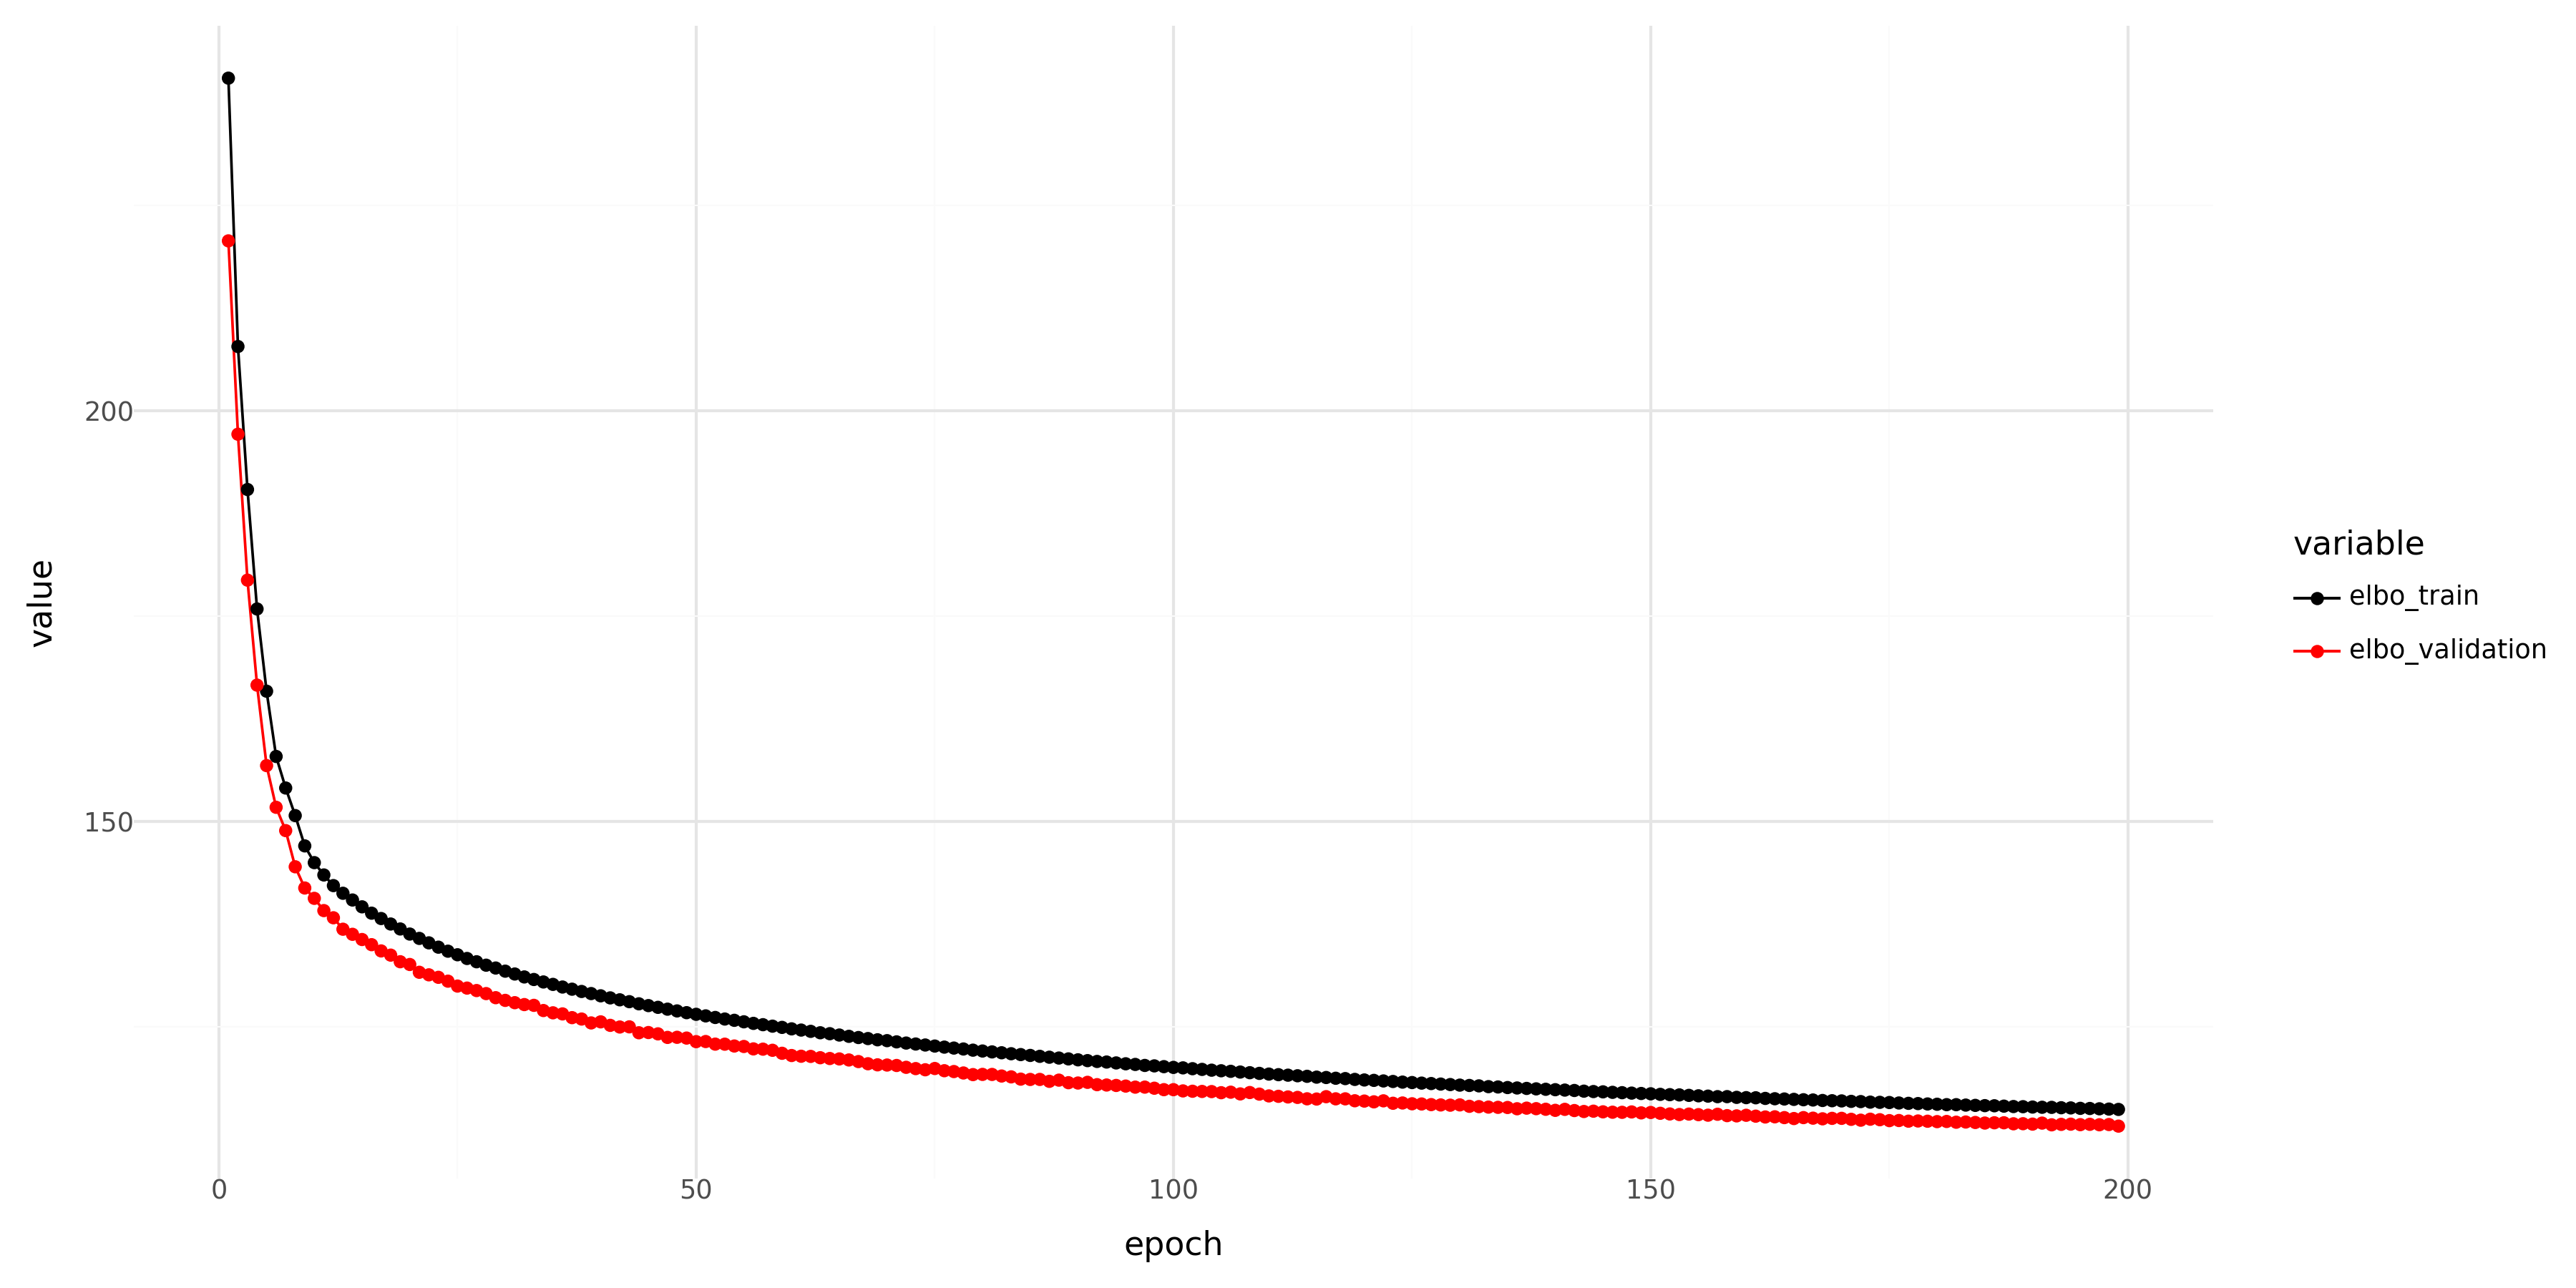

In [72]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

#### Label transfer with `scANVI` 

In [73]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [74]:
scanvi_model.train(200, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1])

INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 200/200: 100%|█| 200/200 [3:13:24<00:00, 62.74s/it, v_num=1, train_loss_step=110, train_loss_epo

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [3:13:24<00:00, 58.02s/it, v_num=1, train_loss_step=110, train_loss_epo


In [75]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [76]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

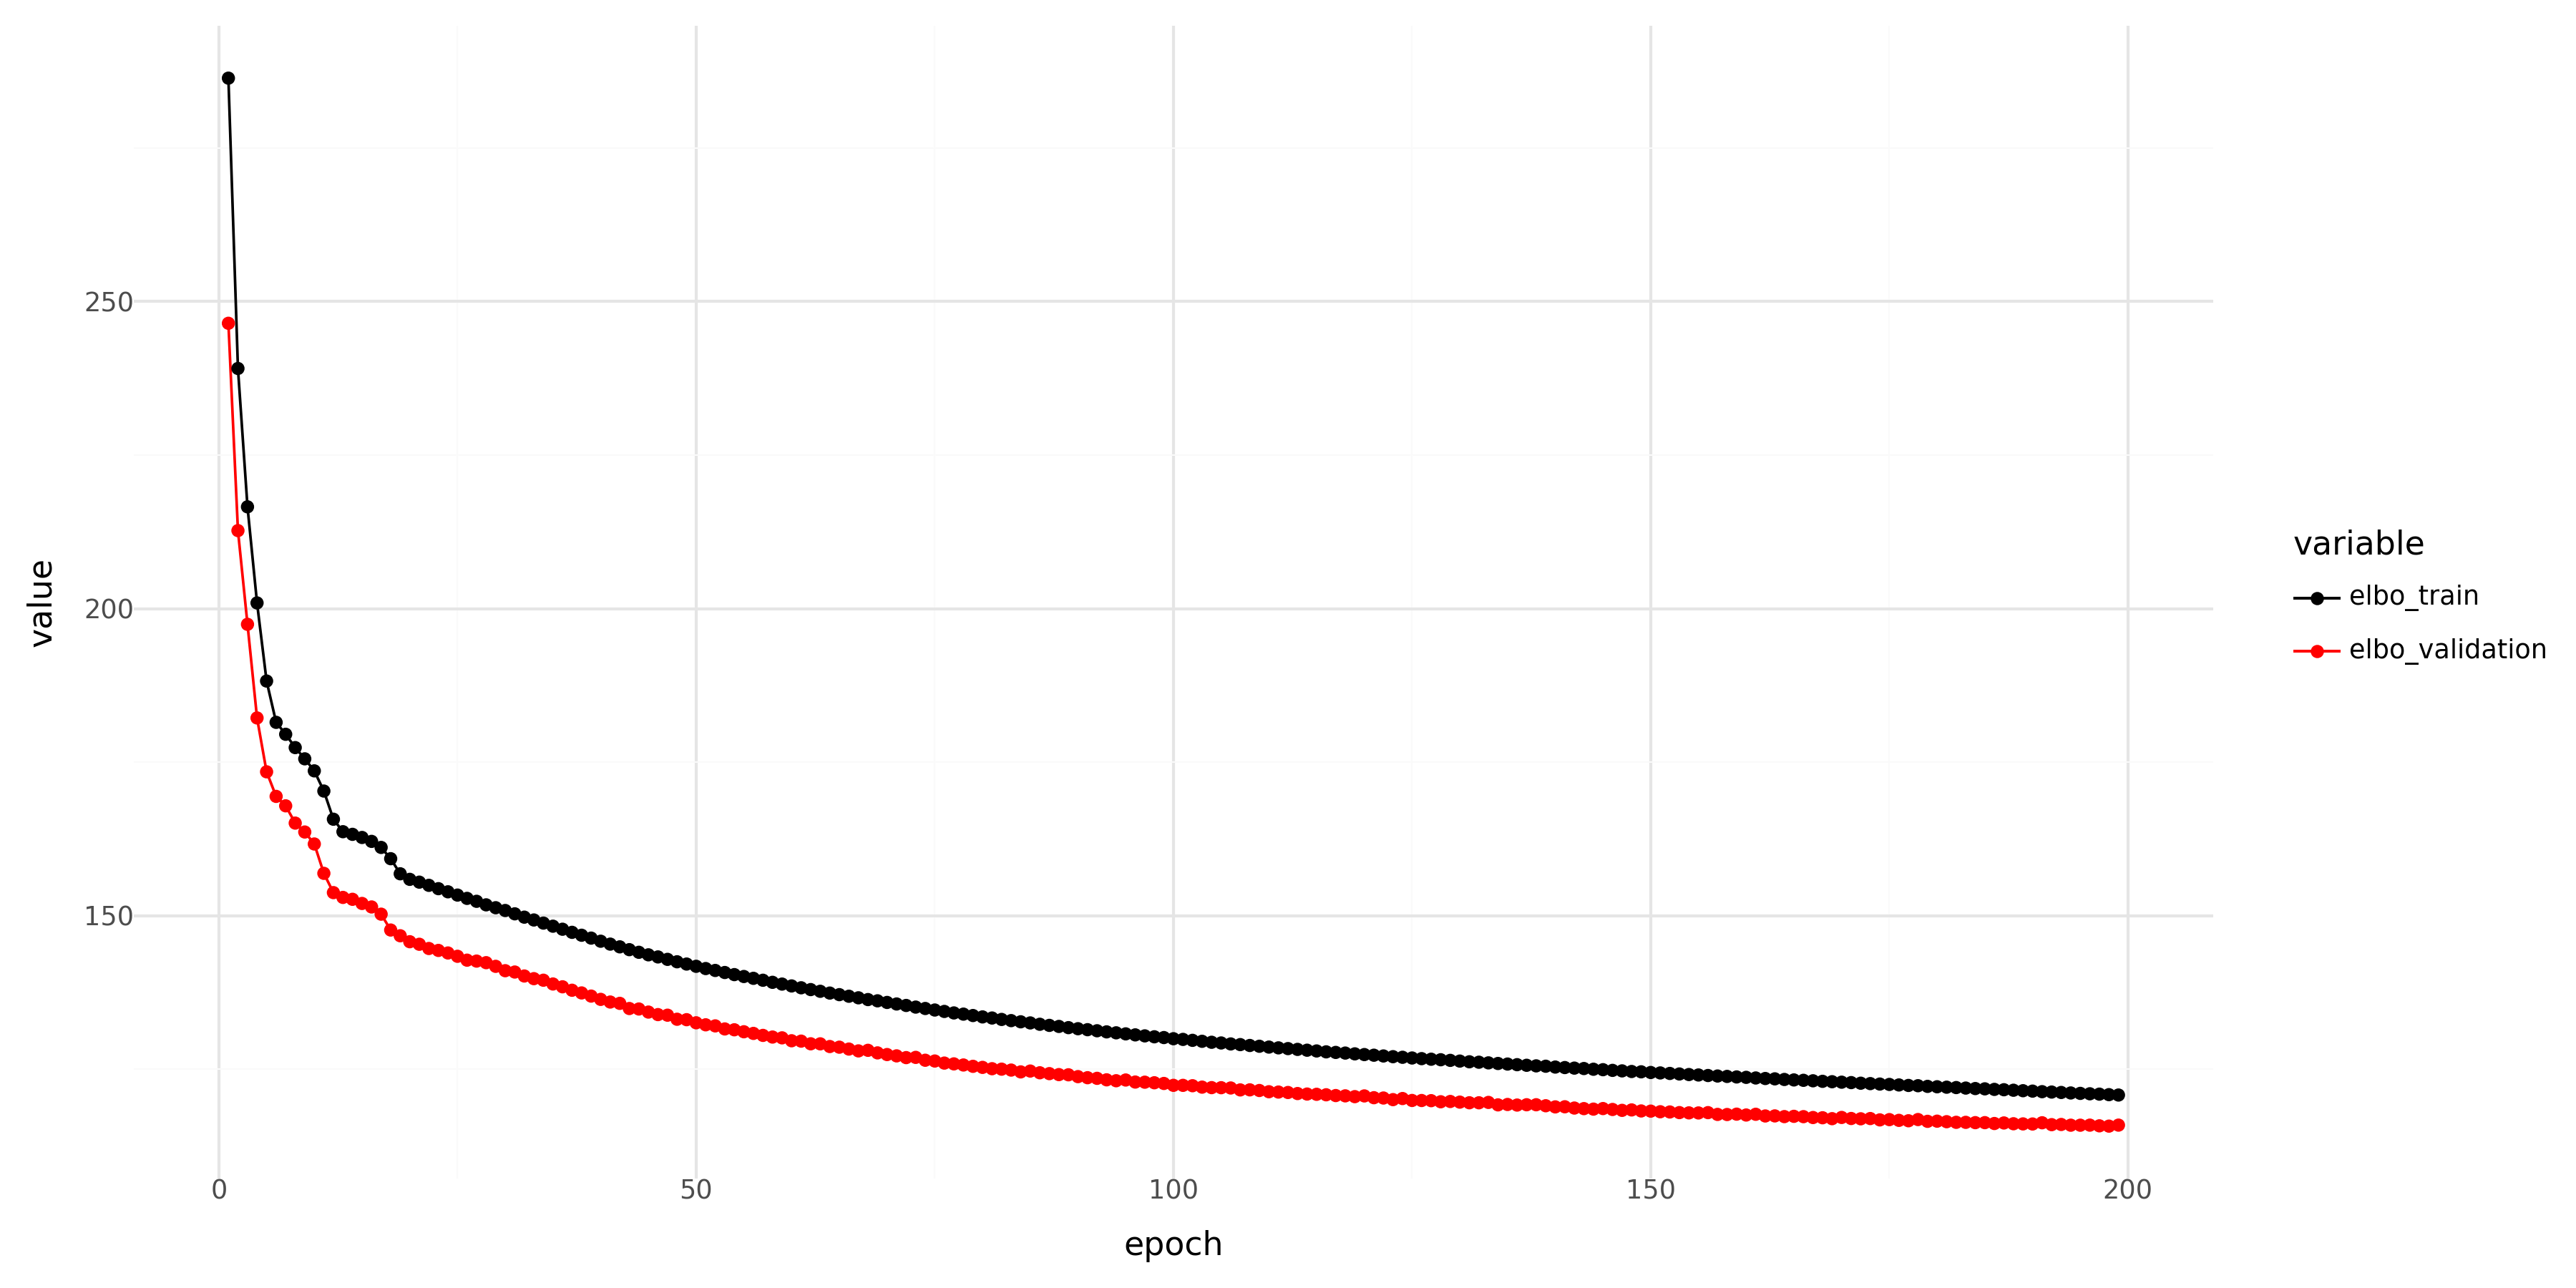

In [77]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

+ Visualize dataset

In [78]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:01)


In [ ]:
adata.obs['C_scANVI'].value_counts()

In [ ]:
sc.set_figure_params(dpi = 300, figsize=(10,7))
sc.pl.umap(adata, color = ['Study_name', 'seed_labels', 'Library_Preparation_Protocol', 'C_scANVI', 'Donor_ID'], ncols = 2, frameon = False, size = 1)

In [81]:
adata_filtered = adata[adata.obs['dataset'] == 'query']

In [82]:
adata_filtered.obs['C_scANVI'].value_counts()

C_scANVI
Myofibroblasts          41772
Fibroblasts             34507
Colonocyte              33630
IgA plasma cell         19093
Stem cells              17811
Enterocyte              14681
Macrophages             12876
Goblet cells            11977
CD4 T                   10807
B cells                 10782
Glial cells              8179
Pericytes                6744
TA                       6646
DC                       6365
BEST4+ epithelial        5687
arterial capillary       4753
EECs                     3784
Tuft cells               3674
Mature venous EC         3643
Mast cells               3058
Plasma cells             2517
Monocytes                2495
CD8 T                    2431
Mature arterial EC       2324
LEC                      1764
Memory B                 1523
Immune Cycling cells     1218
Naive B                   317
NK                        306
Microfold cell            184
ILCs                      171
gdT                        39
B cells AICDA LRMP         34
T

In [83]:
df = adata_filtered.obs['C_scANVI'].value_counts()

In [84]:
adata_filtered.write_h5ad('/../../../gut_project/Processed_data/Gut_data/10X_Xenium_data/Xenium_add_on_data_scANVI_cell_states.h5ad')